# Failure type classification 

This is a POC notebook for analyzing testgrids and generating a report that will identify the tests and dates where 4 different types of failures may have occurred.   

Goal: Auto label test grids with the following types of failures:

* Infra Flake
* Flaky Tests
* Install Flake 
* New Test Failure

Next Steps/To Do:  
* Create visualized results on one grid
* Aggregate results for the whole platform. 

In [1]:
import json
import os
import gzip
import datetime
import pandas as pd
import numpy as np
from IPython.display import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from dotenv import load_dotenv, find_dotenv
import warnings

from ipynb.fs.defs.failure_type_functions import (
    print_report,
    detect_failures,
    normalize,
    format_results,
    CephCommunication,
    decode_run_length,
)

load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

In [2]:
## Specify variables

METRIC_NAME = "failure_type"

# Specify the path for input grid data
INPUT_DATA_PATH = "../../data/raw/testgrid_810.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../data/processed/metrics/{METRIC_NAME}"

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")
s3_input_data_path = "raw_data"
s3_output_data_path = "failure_type"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
## Import data
timestamp = datetime.datetime.today()
filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
# timestamp = datetime.datetime(2021, 4, 14)

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

### Hand annotated example

The image below is a hand annotated testgrid. The aim of this notebook is to automate this process. 

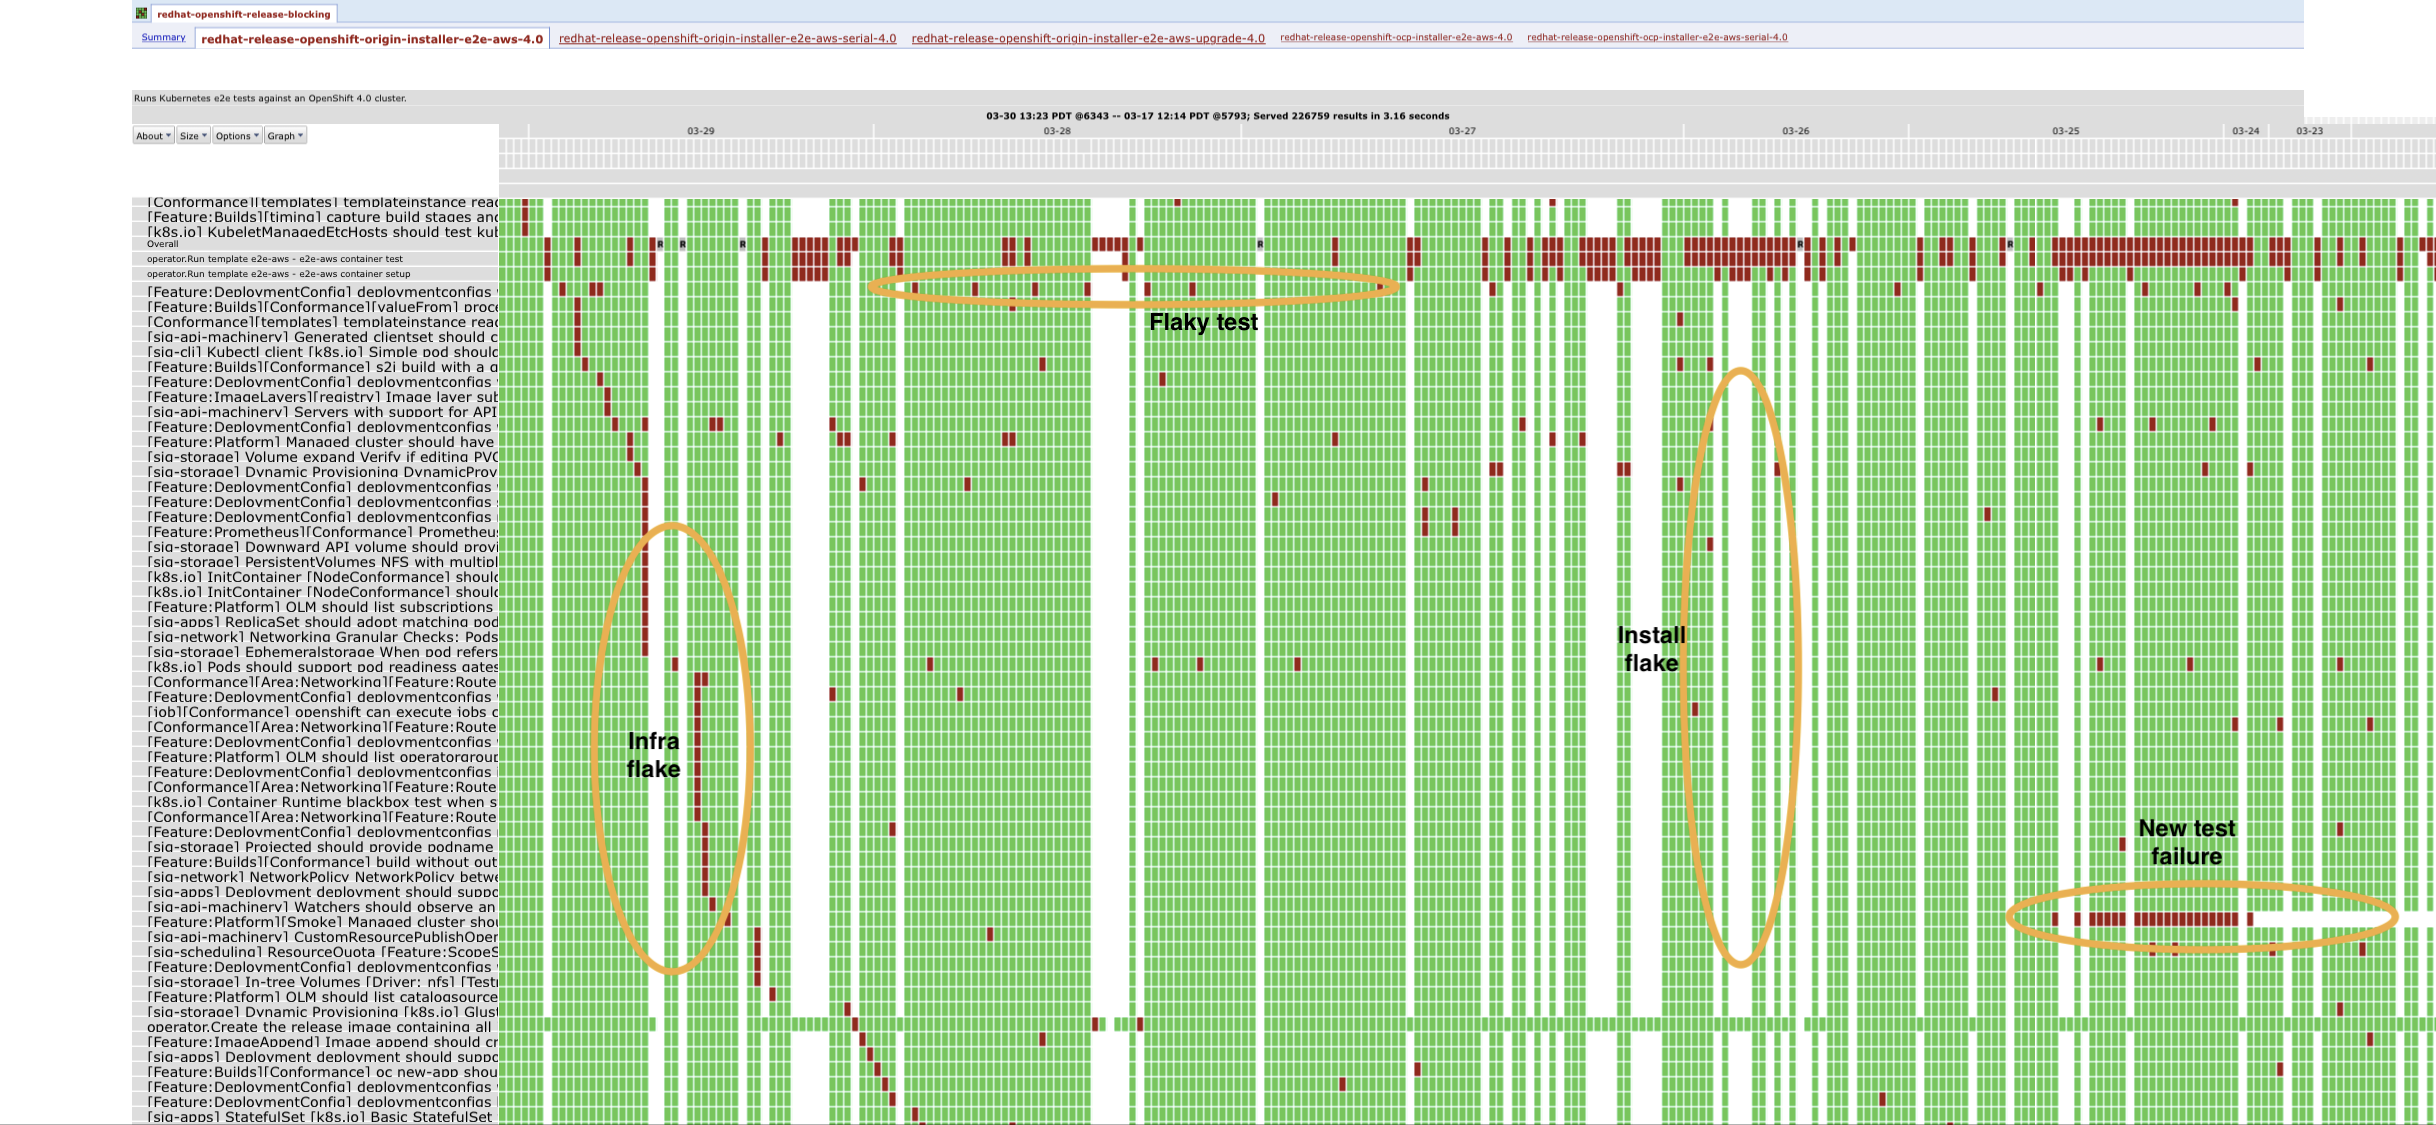

In [4]:
Image(
    "https://user-images.githubusercontent.com/161888/89903201-a62b3800-dbe7-11ea-9b1c-2ec62fe8952f.png"
)

In [5]:
selected_dashboard = '"redhat-openshift-ocp-release-4.3-informing"'
selected_job = "release-openshift-origin-installer-e2e-gcp-compact-4.3"

In [6]:
grid = testgrid_data[selected_dashboard][selected_job]["grid"]

In [7]:
x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))
x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])

## Failure Type Identification 

Bring all 4 methods together to identify the different failure types for a single testgrid and generate a report. We see the test status for the first 50 tests below. Red is failing tests, green is passing tests, and white is tests that were not run.

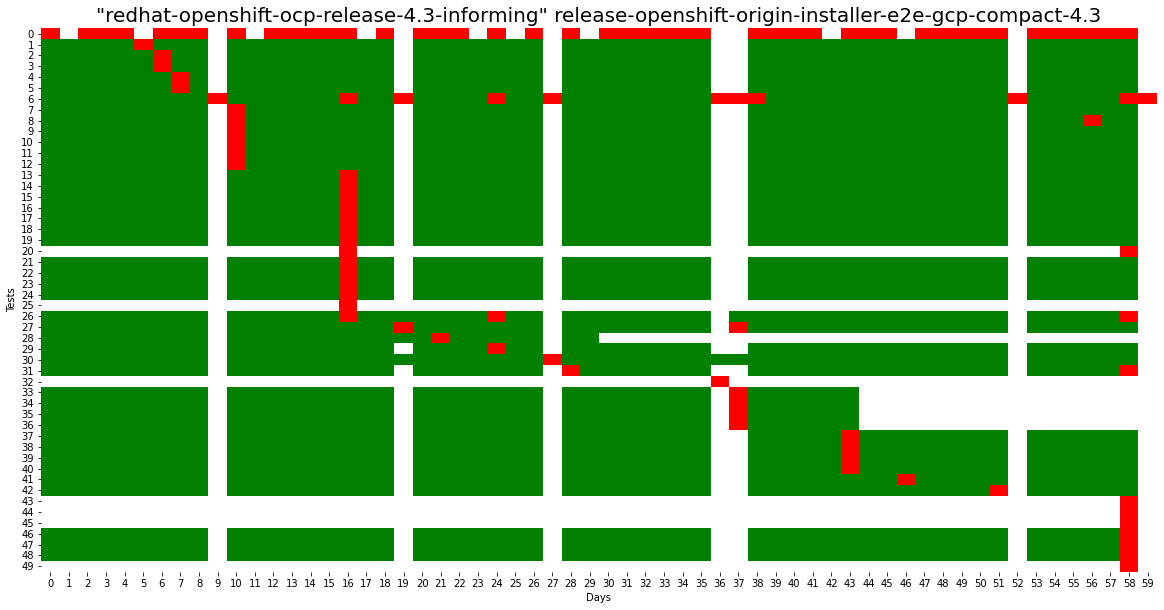

In [8]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["red", "white", "green"])
sns.heatmap(x[:50], fmt="", cmap=cmap, cbar=False)
plt.ylabel("Tests")
plt.xlabel("Days")
plt.title(
    f"{selected_dashboard} {selected_job}",
    fontsize=20,
)
plt.show()

In [9]:
results = detect_failures(testgrid_data, grid, selected_dashboard, selected_job)

In [10]:
print_report(results, selected_dashboard, selected_job)

Failure Report for: 
    "redhat-openshift-ocp-release-4.3-informing"/release-openshift-origin-installer-e2e-gcp-compact-4.3

Flaky Tests:
Test number 6 had flakes at:
2020-09-18 to 2020-09-22
2020-09-10 to 2020-09-14

Infra Flake:
Test number 1 had an infra flake at 2020-10-02
Test number 3 had an infra flake at 2020-10-01

Install Flake:
An install flake started on 2020-09-02
An install flake started on 2020-08-31

New Test Failures:


### Run the analysis for all the dashboards and jobs

In [11]:
results = format_results(results)

In [ ]:
all_results = {}
for dashboard in testgrid_data:
    dashboard_result = {}
    for job in testgrid_data[dashboard]:
        grid = testgrid_data[dashboard][job]["grid"]
        try:
            res = detect_failures(testgrid_data, grid, dashboard, job)
            dashboard_result[job] = format_results(res)
        # We need to look into these errors and fix them
        except (ValueError, AttributeError, KeyError):
            dashboard_result[job] = "Error"
    all_results[dashboard] = dashboard_result

## Save results on Ceph or locally

In [ ]:
if AUTOMATION == "True":
    filename = f"failure_type_report_{timestamp.day}{timestamp.month}_{selected_dashboard}_{selected_job}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_obj = cc.s3_resource.Object(s3_bucket, f"{s3_output_data_path}/{filename}")
    status = s3_obj.put(Body=bytes(json.dumps(all_results).encode("UTF-8")))
else:
    filename = f"failure_type_report_{timestamp.day}{timestamp.month}_{selected_dashboard}_{selected_job}.json"
    dataset_base_path = Path(OUTPUT_DATA_PATH)
    dataset_base_path.mkdir(parents=True, exist_ok=True)
    file_path = f"{OUTPUT_DATA_PATH}/{filename}"
    with open(file_path, "w") as outfile:
        json.dump(all_results, outfile)

We can now take a single test grid and identify the tests and dates where different error types occurred using the 4 heuristic based methods above. We can run these tests in automation using the custom KubeFlow [pipeline](./failure.pipeline) created.

Next, we will use this report to annotate the grids themselves. And finally we will apply this to the entire testgrid dataset to generate some aggregated metrics about this failure types.